### 1. 치타 vs 사자 데이터셋
* [데이터셋] https://www.kaggle.com/datasets/mikoajfish99/lions-or-cheetahs-image-classification/data
* 사자 100장, 치타 100장 -> train 폴더에 80장씩, validation 폴더에 20장씩

### 2. 모듈 호출

In [1]:
import os
import torch                      # 딥러닝 프레임워크 PyTorch의 핵심 모듈
import torch.nn as nn             # 신경망 모델 구축을 위한 모듈
import torch.optim as optim       # 딥러닝 모델 학습 과정에서 파라미터를 최적화하는 옵티마이저를 제공하는 모듈
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms   # PyTorch 전용 컴퓨터 비전 모듈
from torch.utils.data import DataLoader      # 딥러닝 모델 학습 및 테스트를 위한 데이터 로더를 제공하는 모듈

In [2]:
os.environ['KAGGLE_USERNAME'] = 'hwdong2'
os.environ['KAGGLE_KEY'] = '32994a1fc91c0995ca178e96f4a2f71d'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### 3. 이미지 증강 (수나 양을 늘려서 더 강하게 하다)

In [4]:
data_transforms = {
    'train': transforms.Compose([         # 여러 이미지 변환 작업을 하나의 파이프라인으로 연결
        transforms.Resize((224, 224)),    # 이미지 크기 224 x 224 변경 
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), 
        # 0도 회전, 가로세로 10% 찌끄러뜨림, 크기 조정 80% ~ 120% 사이
        transforms.RandomHorizontalFlip(),   # 랜덤으로 수평 뒤집기
        transforms.ToTensor()             # 이미지를 PyTorch 텐서 형태로 변환
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [5]:
# 타겟 값을 받아 PyTorch 텐서 형태로 변환
def target_transforms(target):
    return torch.FloatTensor([target])

In [6]:
# datasets.ImageFolder: 디렉토리 구조를 기반으로 이미지 데이터셋을 로딩
image_datasets = {
    'train': datasets.ImageFolder('data/train', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('data/validation', data_transforms['validation'], target_transform=target_transforms)
}

In [7]:
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

In [8]:
print(len(image_datasets['train']), len(image_datasets['validation']))

160 40


### 4. 데이터 로더 배치 시각화 

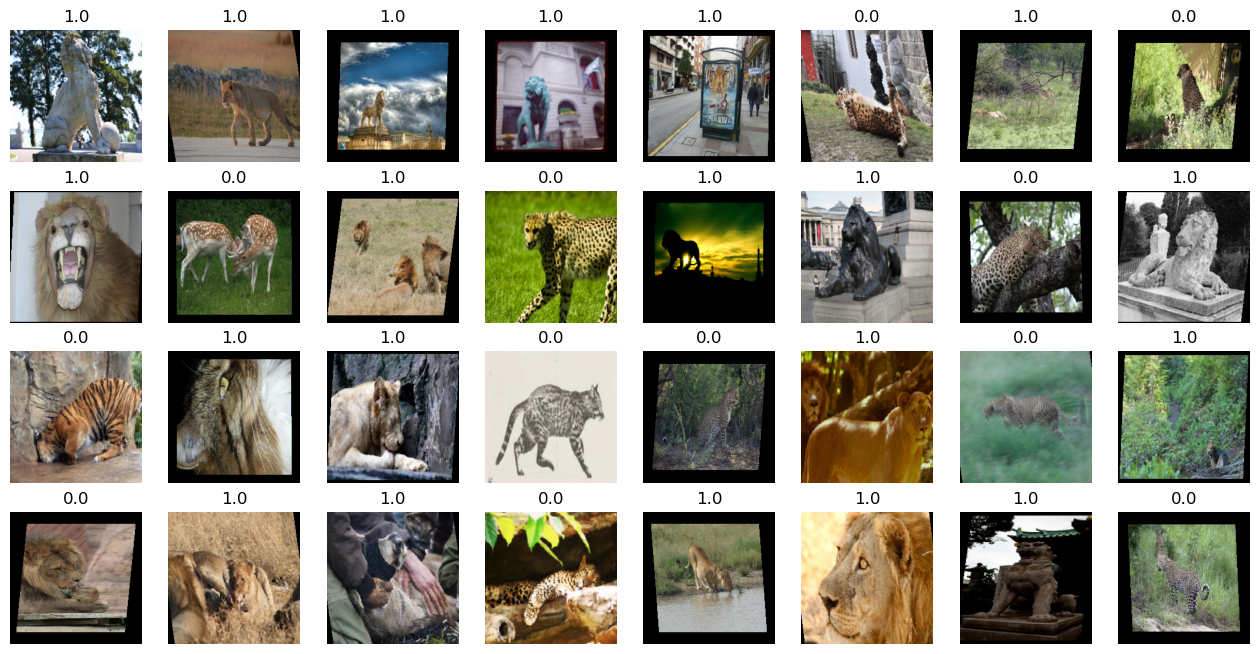

In [9]:
# dataloader를 iterater로 변환한 다음, next를 사용하여 첫 번째 배치 추출
# imgs에는 배치의 이미지들이, labels에는 배치의 레이블들이 저장
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(16, 8))

# axes.flatten()은 2차원 배열인 axes를 1차원 배열로 변환하여 각 서브플롯을 순회
# zip(axes.flatten(), imgs, labels)는 서브플롯(ax), 이미지(img), 레이블(label)을 동시에 순회
for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.permute(1, 2, 0))   # img는 PyTorch 텐서로, 일반적으로 (채널, 높이, 너비) 순서
    ax.set_title(label.item())        # (높이, 너비, 채널) 순서로 변경하여 이미지를 표시할 수 있게 함
    ax.axis('off')                    # label.item(): 텐서 형태의 레이블을 정수로 변환하여, 해당 이미지를 나타내는 제목

### 5. 사전학습된 RestNet-50 모델 적용
* ResNet-50은 50개의 레이어로 구성된 심층 신경망으로, 주로 이미지 분류 작업에 사용
* 사전 학습된 가중치를 사용하면 모델이 일반적인 이미지 특징을 잘 잡아내도록 학습된 상태에서 시작할 수 있음

In [10]:
#  ImageNet 데이터셋(1K 클래스)으로 사전 학습된 가중치를 사용함
model = models.resnet50(weights='IMAGENET1K_V1').to(device) 
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
for param in model.parameters():
    param.requires_grad = False    # 가져온 파라미터를 업데이트 하지 않음

In [12]:
# model.fc는 ResNet-50 모델의 최종 완전 연결 계층(fully connected layer)을 의미
model.fc = nn.Sequential(  # 여러 계층을 순차적으로 실행하는 컨테이너 모듈
    nn.Linear(2048, 128),  # ResNet-50의 출력 피처의 차원 2048을 128차원으로 줄임
    nn.ReLU(),             # 비선형성을 추가하여 모델이 더 복잡한 패턴을 학습
    nn.Linear(128, 1),     # 128차원 피처를 이진 분류를 위한 단일 출력으로 변환
    nn.Sigmoid()           # 활성화 함수로 시그모이드 함수, 이진 분류 문제에서 출력 값을 0과 1 사이의 값으로 변환
).to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 6. 학습

In [13]:
# Adam 옵티마이저를 사용하여 모델의 최종 완전 연결 계층(model.fc)의 파라미터만 업데이트
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()     # 학습 모드
        else:
            model.eval()      # 평가 모드

        # 손실과 정확도 초기화
        sum_losses = 0
        sum_accs = 0

        # 배치별 데이터 로딩 및 모델 예측
        # 데이터 로더에서 배치를 가져와서 -> device로 이동
        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)
            # 모델을 통해 예측 값을 얻고, 이진 교차 엔트로피 손실(BCELoss)을 계산합니다
            loss = nn.BCELoss()(y_pred, y_batch) 

            # 훈련 단계에서 역전파 및 옵티마이저 업데이트
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # 손실과 정확도 누적
            sum_losses = sum_losses + loss

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc

        # 에포크별 평균 손실과 정확도 계산 및 출력
        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.4f} Accuracy: {avg_acc: .2f}')

train     : Epoch    1/10 Loss: 0.7643 Accuracy:  50.00
validation: Epoch    1/10 Loss: 0.5240 Accuracy:  84.38
train     : Epoch    2/10 Loss: 0.5662 Accuracy:  79.38
validation: Epoch    2/10 Loss: 0.4471 Accuracy:  87.50
train     : Epoch    3/10 Loss: 0.4163 Accuracy:  90.62
validation: Epoch    3/10 Loss: 0.3956 Accuracy:  89.06
train     : Epoch    4/10 Loss: 0.3244 Accuracy:  93.75
validation: Epoch    4/10 Loss: 0.3427 Accuracy:  89.06
train     : Epoch    5/10 Loss: 0.3099 Accuracy:  91.25
validation: Epoch    5/10 Loss: 0.3115 Accuracy:  90.62
train     : Epoch    6/10 Loss: 0.2677 Accuracy:  88.75
validation: Epoch    6/10 Loss: 0.2879 Accuracy:  90.62
train     : Epoch    7/10 Loss: 0.2212 Accuracy:  93.75
validation: Epoch    7/10 Loss: 0.3207 Accuracy:  89.06
train     : Epoch    8/10 Loss: 0.2244 Accuracy:  92.50
validation: Epoch    8/10 Loss: 0.2784 Accuracy:  89.06
train     : Epoch    9/10 Loss: 0.1858 Accuracy:  94.38
validation: Epoch    9/10 Loss: 0.2939 Accuracy:

### 7. 치타 사진 vs 사자 사진 분류 테스트

In [14]:
from PIL import Image

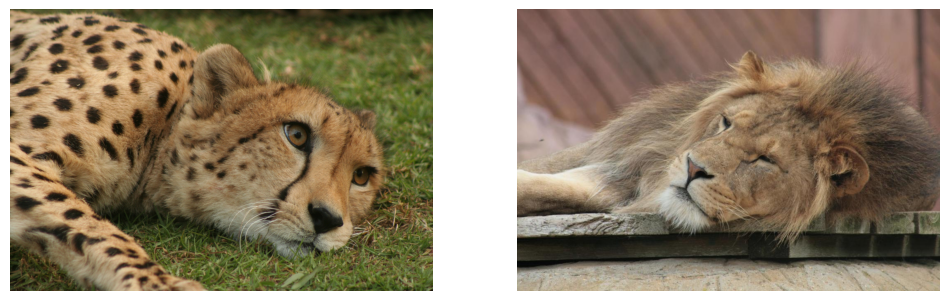

In [64]:
img1 = Image.open('data/validation/Cheetah/a9be4e0ac3ff7f4e.jpg')
img2 = Image.open('data/validation/Lion/d35eb436350a6c04.jpg')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [65]:
# 이미지를 각각 변환
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)

print(img1_input.shape)    # (채널, 높이, 너비) : 3개의 채널(RGB), 224x224 사이즈
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [66]:
# 이미지를 배치로 묶기
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape          # (배치크기, 채널, 높이, 너비)

torch.Size([2, 3, 224, 224])

In [67]:
y_pred = model(test_batch)

In [68]:
y_pred

tensor([[0.0029],
        [0.9777]], grad_fn=<SigmoidBackward0>)

(-0.5, 1023.5, 682.5, -0.5)

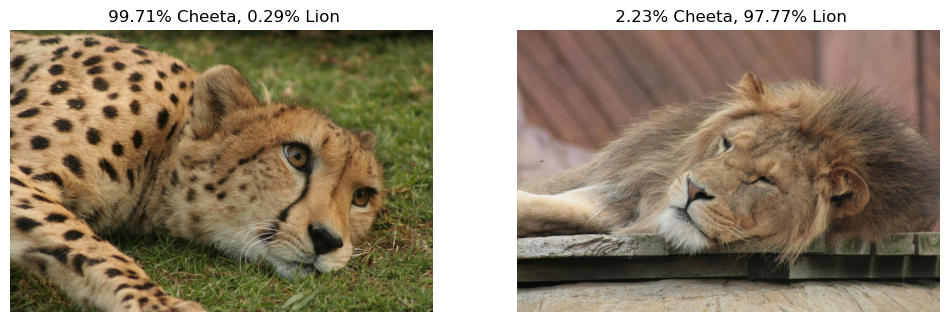

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title(f'{(1-y_pred[0, 0])*100: .2f}% Cheeta, {(y_pred[0, 0])*100:.2f}% Lion')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1, 0])*100: .2f}% Cheeta, {(y_pred[1, 0])*100:.2f}% Lion')
axes[1].imshow(img2)
axes[1].axis('off')

### 8. 래퍼 치타 vs 카카오프렌즈 라이언 분류 테스트

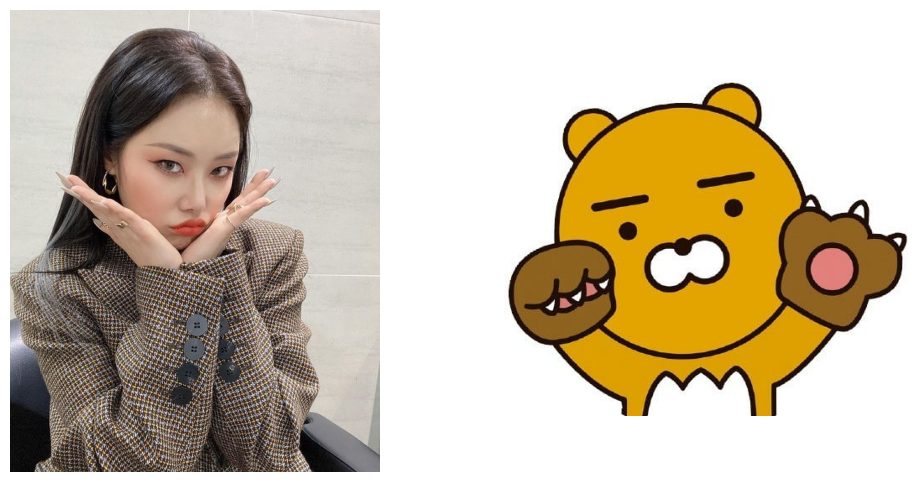

In [79]:
img1 = Image.open('data/validation/Cheetah/rapper.jpg')
img2 = Image.open('data/validation/Lion/kakao.jpg')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [80]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)

print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [81]:
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [82]:
y_pred = model(test_batch)
y_pred

tensor([[0.7149],
        [0.7493]], grad_fn=<SigmoidBackward0>)

(-0.5, 503.5, 416.5, -0.5)

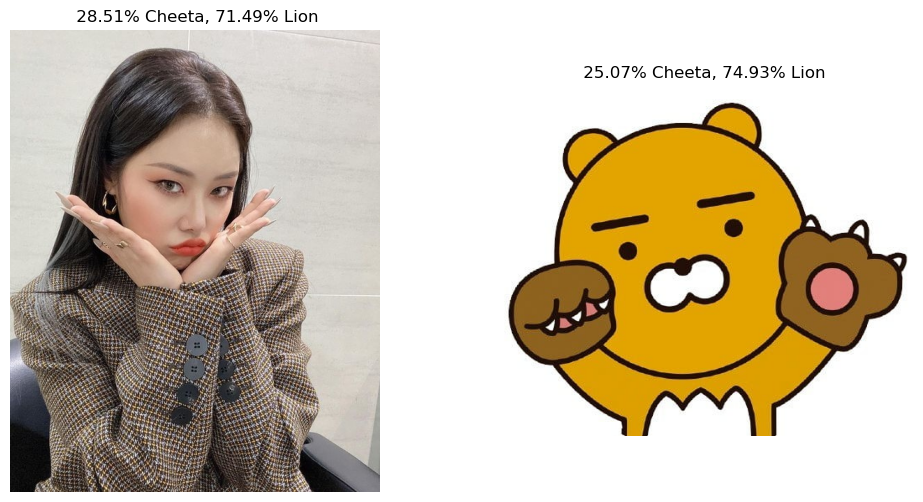

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title(f'{(1-y_pred[0, 0])*100: .2f}% Cheeta, {(y_pred[0, 0])*100:.2f}% Lion')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1, 0])*100: .2f}% Cheeta, {(y_pred[1, 0])*100:.2f}% Lion')
axes[1].imshow(img2)
axes[1].axis('off')